In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from scipy.optimize import fmin
from taskchain.task import Config
from ttopt import TTOpt

from rcpl import config
from rcpl.config import BASE_DIR
from rcpl.rcpl import random_cyclic_plastic_loading

DEVICE = 'cuda'

In [3]:
df_exp = pd.read_csv(BASE_DIR / 'data' / 'AluminumStabilizationDiskr.csv')
df_exp['epsp'] = df_exp['eps'] - df_exp['sig']/68000

In [4]:
epsp = df_exp['epsp'].to_numpy()[:603]

In [5]:
theta_best_until_now = {
    'k0': np.array([37.927], dtype=np.float64),
    'kap': np.array([504.27, 0.011648], dtype=np.float64),
    'c': np.array([5139.7, 577.36, 1.0063, 7.74E-06], dtype=np.float64),
    'a': np.array([79.433, 79.121, 165.7, 5.2683], dtype=np.float64) * np.sqrt(2/3),
}
theta_best_until_now = np.concatenate(list(theta_best_until_now.values()))

In [6]:
config_path = config.CONFIGS_DIR / 'model' / 'fixed' / 'gru4-custom' / 'gru6.yaml'
conf = Config(
    config.TASKS_DIR,  # where Taskchain data should be stored
    config_path,
    context={'device': DEVICE},
    global_vars=config,  # set global variables
)
chain = conf.chain()
chain.set_log_level('CRITICAL')

In [7]:
net = chain.trained_model.value
torch_exp = torch.unsqueeze(torch.from_numpy(chain.real_experiment.value['2023-08-27']), 0).float().to(DEVICE)
net.eval()
with torch.no_grad():
    theta_hat = net(torch_exp)

In [8]:
theta_nn = chain.unscale_params_torch.value(theta_hat).cpu().numpy()[0]
theta_nn

array([9.8670944e+01, 2.2424414e+03, 9.1040060e-03, 7.0439580e+03,
       1.9199489e+03, 4.3101718e+02, 5.4088953e+02, 1.7381474e+01,
       1.8341549e+01, 1.3937408e+01, 7.8522995e+01], dtype=float32)

In [9]:
SIG_EXP = np.expand_dims(df_exp['sig'][:603],0)

def random_cyclic_plastic_loading_theta(theta):
    kappa_dim = 2
    dim = 4
    return random_cyclic_plastic_loading(
            k0=theta[:1],
            kap=theta[1:1 + kappa_dim],
            c=theta[1 + kappa_dim:1 + kappa_dim + dim],
            a=theta[1 + kappa_dim + dim:],
            epsp=epsp,
    )

def to_optimize(thetas) -> float:
    res = np.zeros((thetas.shape[0], 603))
    for i, theta in enumerate(thetas):
        res[i] = random_cyclic_plastic_loading_theta(theta)
    return np.mean((res - SIG_EXP)[:, :] ** 2, axis=1)

def to_optimize_one(theta) -> float:
    res = random_cyclic_plastic_loading_theta(theta)
    return np.mean((res - SIG_EXP[0])[:] ** 2)

In [10]:
np.random.seed(42)

d = 11                      # Number of function dimensions:
rank = 10                   # Maximum TT-rank while cross-like iterations

# We initialize the TTOpt class instance with the correct parameters:
tto = TTOpt(
    f=to_optimize,          # Function for minimization. X is [samples, dim]
    d=d,                    # Number of function dimensions
    a=[15,100,1/150, 1000, 50, 50, 50,0,0,0,0],                 # Grid lower bound (number or list of len d)
    b=[250,10000,1/30,10000, 2000, 2000, 2000,350,350,350,350],                 # Grid upper bound (number or list of len d)
    p=2,                    # The grid size factor (there will n=p^q points)
    q=20,                   # The grid size factor (there will n=p^q points)
    evals=1.E+5,            # Number of function evaluations
    name='Alpine',          # Function name for log (this is optional)
    x_opt_real=np.ones(d),  # Real value of x-minima (x; this is for test)
    y_opt_real=0.,          # Real value of y-minima (y=f(x); this is for test)
    with_log=False)

# And now we launch the minimizer:
tto.optimize(rank)

# We can extract the results of the computation
theta_ttopt = tto.x_opt

/home/martin/miniconda3/envs/t2/lib/python3.10/site-packages/numba/np/arraymath.py:344: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  return compiled(arr, axis)


In [11]:
# Using the Nelder-Mead Simplex algorithm to find the minimum
theta_nn_optimized = fmin(to_optimize_one, theta_nn, xtol=1e-8)
theta_ttopt_optimized = fmin(to_optimize_one, theta_ttopt, xtol=1e-8)

/home/martin/miniconda3/envs/t2/lib/python3.10/site-packages/numba/np/arraymath.py:344: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  return compiled(arr, axis)
/tmp/ipykernel_92209/3721212625.py:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  theta_nn_optimized = fmin(to_optimize_one, theta_nn, xtol=1e-8)
/tmp/ipykernel_92209/3721212625.py:3: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  theta_ttopt_optimized = fmin(to_optimize_one, theta_ttopt, xtol=1e-8)


In [12]:
theta_nn_optimized

array([ 4.1715500e+01,  4.0242566e+02,  1.1204153e-02,  3.0661562e+03,
        6.6542930e+03,  6.1589380e+02,  5.0696094e+02,  3.7890907e+01,
        3.5342514e+01, -3.9535236e+00,  6.3512344e+01], dtype=float32)

In [13]:
predicted_sigs = {
    'sig_best_until_now': random_cyclic_plastic_loading_theta(theta_best_until_now),
    'sig_ttopt': random_cyclic_plastic_loading_theta(theta_ttopt),
    'sig_ttopt_optimized': random_cyclic_plastic_loading_theta(theta_ttopt_optimized),
    'sig_nn': random_cyclic_plastic_loading_theta(theta_nn),
    'sig_nn_optimized': random_cyclic_plastic_loading_theta(theta_nn_optimized),
}

In [14]:
for key, val in predicted_sigs.items():
    print(f'Average L2 distance of {key:<20}:', np.mean((SIG_EXP[0]-val)**2))

Average L2 distance of sig_best_until_now  : 561.830688169428
Average L2 distance of sig_ttopt           : 585.865383273676
Average L2 distance of sig_ttopt_optimized : 563.2886834204078
Average L2 distance of sig_nn              : 1114.772439555944
Average L2 distance of sig_nn_optimized    : 564.293493857173


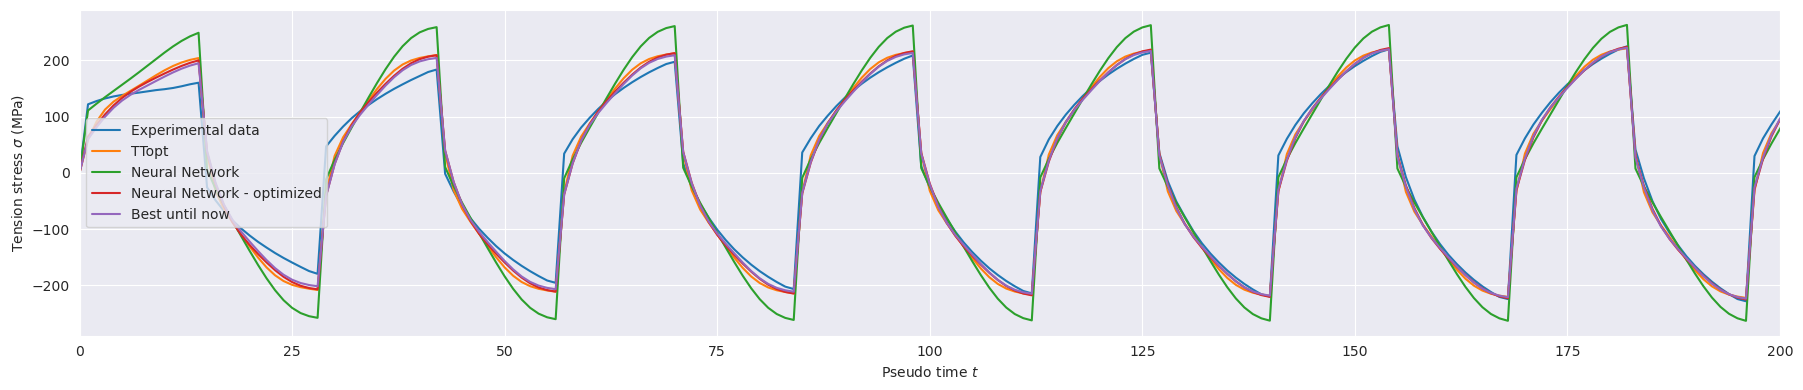

In [15]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,4))
    sns.lineplot(SIG_EXP[0], label='Experimental data')
    # sns.lineplot(df_sim[:200]['sig'], label='sim')
    plt.xlabel('Pseudo time $t$')
    plt.ylabel('Tension stress $\\sigma$ (MPa)')
    sns.lineplot(predicted_sigs['sig_ttopt'], label='TTopt')
    sns.lineplot(predicted_sigs['sig_nn'], label='Neural Network')
    sns.lineplot(predicted_sigs['sig_nn_optimized'], label='Neural Network - optimized')
    sns.lineplot(predicted_sigs['sig_best_until_now'], label='Best until now')
    plt.tight_layout()
    plt.xlim((0,200))
    plt.plot()

[]

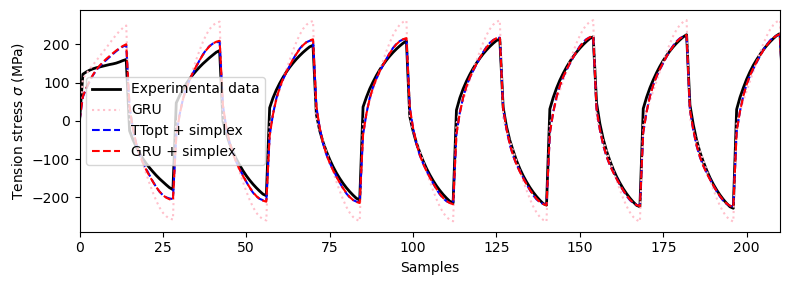

In [16]:
plt.figure(figsize=(8, 2.95))
sns.lineplot(SIG_EXP[0], label='Experimental data', color='black', lw=2)
plt.xlabel('Samples')
plt.ylabel('Tension stress $\\sigma$ (MPa)')
sns.lineplot(predicted_sigs['sig_nn'], label='GRU', color='pink', ls='dotted')
sns.lineplot(predicted_sigs['sig_ttopt_optimized'], label='TTopt + simplex', color='blue', ls='--')
sns.lineplot(predicted_sigs['sig_nn_optimized'], label='GRU + simplex', color='red', ls='--')
plt.tight_layout()
plt.xlim((0,14*15))
# plt.savefig('ttopt_comparison.pdf', bbox_inches='tight', pad_inches=0)
plt.plot()